In [1]:
import os, os.path
import numpy as np
import pandas as pd
from data_structures import *
from model_afolu import *
from model_ippu import *
from model_circular_economy import *
from model_energy import *
from model_socioeconomic import *
from setup_analysis import *
from support_functions import *
import importlib
import time
import warnings
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
"""
importlib.reload(ds)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
"""

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:721: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


'\nimportlib.reload(ds)\nimportlib.reload(sa)\nimportlib.reload(sf)\nimportlib.reload(ma)\nimportlib.reload(mc)\nimportlib.reload(mi)\nimportlib.reload(me)\nimportlib.reload(se)\n'

In [2]:
#importlib.reload(ds)
#importlib.reload(sa)
#importlib.reload(ma)

# load latest data
df_base_inputs =  pd.read_csv(os.path.join(dir_ref, "fake_data", "fake_data_complete.csv"))
df_input_data = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_07_31_test.csv")
df_mean_transition_0 = pd.read_csv(fp_csv_transition_probability_estimation_mean)
dict_rename = dict([(x, f"pij_lndu_{x}") for x in df_mean_transition_0.columns if (x not in ["country", "year", "optimization_bound"])])
df_mean_transition_0.rename(columns = dict_rename, inplace = True)

# set up some required components
optimization_approach = "max_diagonal"
all_countries = sorted(list(set(df_input_data["Nation"])))

# setup data frame dictionary
dict_df_input = {}
dict_df_mts = {}
for country in all_countries:
    # update mean transition data frames
    df_mts = df_mean_transition_0[
        df_mean_transition_0["country"].isin([country]) & 
        df_mean_transition_0["optimization_bound"].isin([optimization_approach])
    ].copy().reset_index(drop = True)
    dict_df_mts.update({country: df_mts})
    
    # update input data data frames
    df_input = df_input_data[df_input_data["Nation"] == country].reset_index(drop = True).copy();
    dict_df_input.update({country: df_input})
    
fields_pij_to_replace_in_input = [x for x in df_mean_transition_0.columns if (x not in ["country", "year", "optimization_bound"])]
    
    
# initialize the model
model_afolu = AFOLU(model_attributes)



###  NEED TO INTEGRATE THIS INTO MODEL AFOLU

def format_markov_matrix_as_field(
    mat: np.ndarray,
    key_vals: list,
    field_key: str = "key"
) -> pd.DataFrame:
    
    # setup as matrix
    df_mat = pd.DataFrame(mat, columns = key_vals)
    df_mat[field_key] = key_vals
    df_mat_melt = pd.melt(df_mat, id_vars = [field_key], value_vars = key_vals).sort_values(by = [field_key, "variable"])
    
    # get field names
    fields_names = model_attributes.build_varlist(
        model_afolu.subsec_name_lndu, 
        model_afolu.modvar_lndu_prob_transition, 
        restrict_to_category_values = key_vals
    )
    
    df_mat_melt["field"] = fields_names
    df_mat_melt.set_index("field", inplace = True)
    df_mat_melt = df_mat_melt[["value"]].transpose().reset_index(drop = True)
    # doing this only to drop index
    df_out = pd.DataFrame()
    df_out[df_mat_melt.columns] = df_mat_melt[df_mat_melt.columns]
    
    return df_out



In [ ]:

# initialize some relevant info
crop_area_total = 0.0
t_0 = time.time()
attr_lndu = model_attributes.get_attribute_table(model_attributes.subsec_name_lndu)

# get some indices
dict_kv_inds = dict(zip(attr_lndu.key_values, [attr_lndu.get_key_value_index(x) for x in attr_lndu.key_values]))
# update parameters governing change in transition probabilities
time_period_stable = None # set to none to default to the last time step
scalar_into_cropland = 2.28
scalar_into_forest = 0.99
dict_inds_input = {
    (dict_kv_inds["forests_primary"], dict_kv_inds["wetlands"]): 1,
    (dict_kv_inds["forests_primary"], dict_kv_inds["grasslands"]): 5.5,
    (dict_kv_inds["forests_primary"], dict_kv_inds["other"]): 0.98,
    (dict_kv_inds["forests_secondary"], dict_kv_inds["grasslands"]): 1.15,
    (dict_kv_inds["forests_secondary"], dict_kv_inds["other"]): 0.96,
    (dict_kv_inds["croplands"], dict_kv_inds["grasslands"]): 1.15,
    (dict_kv_inds["grasslands"], dict_kv_inds["grasslands"]): 1.02
}

# save off so we have latest assumptions
dict_transition_prob_transformation_assumptions = {
    "attr_lndu": attr_lndu,
    "dict_inds_input": dict_inds_input,
    "scalar_into_cropland": scalar_into_cropland,
    "scalar_into_forest": scalar_into_forest,
    "time_period_stable": time_period_stable
}


#scalar_into_forest_secondary = 0.98
#scalar_into_pstr = 3
#scalar_into_other = 0.98
global ind_pstr
ind_crop = attr_lndu.get_key_value_index(model_afolu.cat_lndu_crop)
ind_frst_primary = attr_lndu.get_key_value_index("forests_primary")
ind_frst_secondary = attr_lndu.get_key_value_index("forests_secondary")
ind_other = attr_lndu.get_key_value_index("other")
ind_pstr = attr_lndu.get_key_value_index(model_afolu.cat_lndu_pstr)

# turn off warnings
warnings.filterwarnings("ignore")

# setup the callback function
global countries_ord
global vec_crop_area_total
global vec_pstr_area_total
countries_ord = []
vec_crop_area_total = []
vec_pstr_area_total = []

def get_result(result_tuple):
    
    global countries_ord
    global vec_crop_area_total
    global vec_pstr_area_total
    
    result, country = result_tuple
    
    vec_sum_crop = np.sum(
        model_attributes.get_standard_variables(
            result, 
            model_afolu.modvar_agrc_area_crop, 
            return_type = "array_base"
        ), 
        axis = 1
    )
    
    vec_sum_pstr = model_attributes.get_standard_variables(
        result, 
        model_afolu.modvar_lndu_area_by_cat, 
        return_type = "array_base"
    )[:, ind_pstr]

    countries_ord.append(country)
    vec_crop_area_total.append(vec_sum_crop)
    vec_pstr_area_total.append(vec_sum_pstr)
    
    
## function to perform scaling
def scale_transitions(
    transition_scalar_crop: float,
    transition_scalar_frst_primary: float,
    df_input: pd.DataFrame,
    df_mean_transition: pd.DataFrame,
    ind_crop: int,
    ind_frst_primary: int,
    dict_scalars: dict,
    model_afolu: AFOLU = model_afolu,
    model_attributes: ModelAttributes = model_attributes,
    time_period_stable: int = None
) -> pd.DataFrame:
    
    # get the time period where transition probabilities become stable
    time_period_stable = int(max(df_input[model_attributes.dim_time_period])) if (time_period_stable is None) else time_period_stable
    time_period_stable = max(min(df_input[model_attributes.dim_time_period]), time_period_stable)
    time_period_stable = min(max(df_input[model_attributes.dim_time_period]), time_period_stable)
    
    # get arrays
    for k in fields_pij_to_replace_in_input:
        df_input[k] = float(df_mean_transition[k])
    arrs_transition = model_afolu.get_markov_matrices(df_input, len(df_input))[0]
    mat_q = arrs_transition[0]
    # setup nodes to increase (cropland remaining)
    trans_c_to_c = mat_q[ind_crop, ind_crop]

    # don't allow cropland into cropland to exceed 1
    if (trans_c_to_c*transition_scalar_crop > 1):
        inds = [x for x in range(len(mat_q)) if (x != ind_crop)]
        dict_inds = dict(zip([(x, ind_crop) for x in inds], [transition_scalar_crop for x in inds]))
        # set scalar for crop to crop
        scalar_crop_to_crop = (1 + trans_c_to_c)/(2*trans_c_to_c)
        dict_inds.update({(ind_crop, ind_crop): scalar_crop_to_crop})
    else:
        dict_inds = {(ind_crop, ): transition_scalar_crop}
    
    # update forest, other, pastures
    dict_inds.update({
        (ind_frst_primary, ): transition_scalar_frst_primary
    })
    dict_inds.update(dict_scalars)

    mat_q_final = model_afolu.adjust_transition_matrix(arrs_transition[0], dict_inds)

    # build dataframe
    df_q = df_mean_transition.copy()
    df_q[model_attributes.dim_time_period] = 0
    df_q_final = format_markov_matrix_as_field(mat_q_final, attr_lndu.key_values)
    df_q_final[model_attributes.dim_time_period] = time_period_stable
    df_q = pd.concat([df_q[df_q_final.columns], df_q_final], axis = 0).reset_index(drop = True)
    df_q = pd.merge(df_input[[model_attributes.dim_time_period]], df_q, how = "left")
    df_q.interpolate(inplace = True)

    for k in df_q.columns:
        df_input[k] = np.array(df_q[k])

    return df_input, df_q


# setup output transitions
df_q_out = []


if __name__ == "__main__":
    
    pool = mp.Pool()

    iterator = all_countries#["dominican_republic"]#["costa_rica"]:
        
    for country in enumerate(iterator):
        
        ind, country = country
        
        # filter and prepare
        df_input = dict_df_input[country];
        df_cat = df_base_inputs[[x for x in df_base_inputs.columns if x not in df_input.columns]]
        df_input = pd.concat([df_input, df_cat], axis = 1)

        # update some fields
        df_input["frac_agrc_initial_yield_feed_sugar_cane"] = 0
        df_input["lndu_reallocation_factor"] = 0
        df_input["elasticity_agrc_sugar_cane_demand_to_income"] = 0.05

        ##  update transitions with scalar
        df_input, df_q = scale_transitions(
            scalar_into_cropland,
            scalar_into_forest,
            df_input,
            dict_df_mts[country],
            ind_crop,
            ind_frst_primary, 
            dict_inds_input,
            time_period_stable = time_period_stable
        )

        # add country field back into output and add to data frame
        df_q["country"] = country
        if len(df_q_out) == 0:
            df_q_out = [df_q for x in iterator]
        else:
            df_q_out[ind] = df_q[df_q_out[0].columns]
        
        pool.apply_async(
            model_afolu.project,
            args = (df_input, country),
            callback = get_result
        )
        
    pool.close()
    pool.join()

# some aggregations after collecting output
df_q_out = pd.concat(df_q_out, axis = 0).sort_values(by = ["country", model_attributes.dim_time_period]).reset_index(drop = True)

vec_crop_trajectory = np.sum(np.array(vec_crop_area_total), axis = 0)
vec_pstr_trajectory = np.sum(np.array(vec_pstr_area_total), axis = 0)

# some notifications
t_elapse = np.round(time.time() - t_0, 2)
print(f"Runs complete.\n\tTotal time: {t_elapse} seconds\n")

# check crops
dif = np.round(vec_crop_trajectory[-1]/vec_crop_trajectory[0], 3)
print(f"With scalar at {scalar_into_cropland}:\t{dif}")

# check grassland
dif = np.round(vec_pstr_trajectory[-1]/vec_pstr_trajectory[0], 3)
print(f"Change in grassland:\t{dif}")

if False:
    # write output
    df_q_out.to_csv(
        fpt_csv_transition_probability_estimation_mean_with_growth%(optimization_approach),
        index = None,
        encoding = "UTF-8"
    )
    # write assumptions to accompanying file
    fp_pkl = fpt_pkl_transition_probability_estimation_mean_with_growth_assumptions%(optimization_approach)
    with open(fp_pkl, "wb") as fp:
        pickle.dump(dict_transition_prob_transformation_assumptions, fp, protocol=pickle.HIGHEST_PROTOCOL)

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_soil
0,813.663257,-1030.972719,227.647708,82.736911,871.316570,159.096606
1,813.661699,-1025.619247,233.051810,81.756445,868.840940,157.034352
2,775.085072,-1020.060585,238.345766,81.669457,867.916507,153.230133
3,778.589744,-1014.291865,243.526325,81.595064,867.125919,153.492282
4,781.959953,-1008.317900,248.590383,81.532977,866.466105,153.753307
5,785.195196,-1002.143610,253.534980,81.482893,865.933863,154.012858
6,788.295179,-995.774012,258.357309,81.444505,865.525896,154.270596
7,791.259818,-989.455392,263.054710,81.417490,865.238801,154.526191
8,794.089234,-982.946545,267.624680,81.401517,865.069059,154.779323
9,796.783755,-976.252970,272.064867,81.396249,865.013077,155.029686


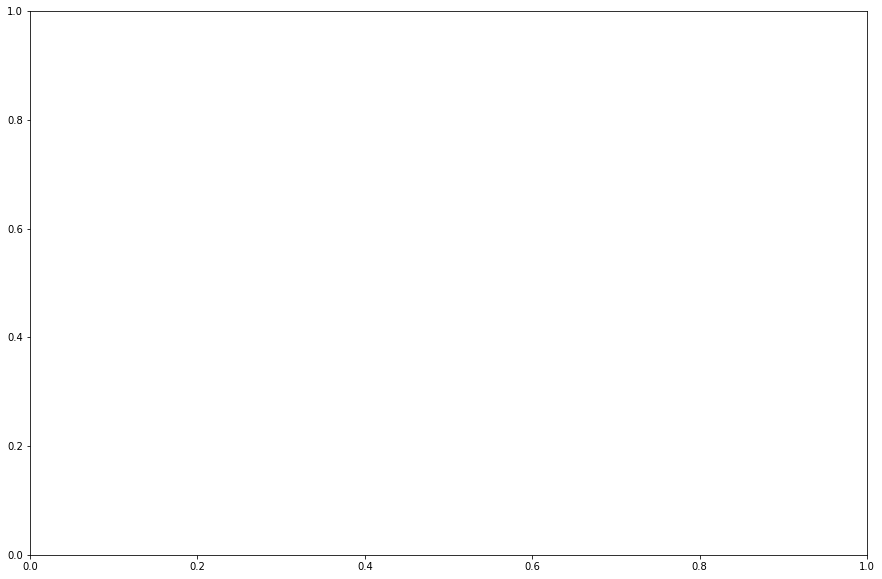

In [66]:
df_output = model_afolu.project(df_input)
fig, ax = plt.subplots(figsize = (15, 10))
#df_output[[x for x in df_output.columns if ("frac_area" in x) and ("calculated" in x)]].plot.area(ax = ax)
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot.area(ax = ax)
df_output[[x for x in df_output.columns if ("emission_co2e" in x) and ("subsector" in x)]]#.plot.area(ax = ax)

In [49]:
[x for x in df_input.columns if "carrying" in x]

['scalar_lvst_carrying_capacity']

In [66]:
#dict_kv_inds = dict(zip(attr_lndu.key_values, [attr_lndu.get_key_value_index(x) for x in attr_lndu.key_values]))


#df_out = model_afolu.project(df_input)
#df_out[[x for x in df_out.columns if ("area_lndu" in x) and ("conversion" not in x)]]

In [23]:
df_input[[x for x in df_input.columns if ("pij" in x) and ("to_other" in x)]]

,pij_lndu_croplands_to_other,pij_lndu_forests_mangroves_to_other,pij_lndu_forests_primary_to_other,pij_lndu_forests_secondary_to_other,pij_lndu_grasslands_to_other,pij_lndu_other_to_other,pij_lndu_settlements_to_other,pij_lndu_wetlands_to_other
0,0.000192,0.0,0.003995,0.0,0.000238,0.998500,0.0,0.0
1,0.000183,0.0,0.004450,0.0,0.000218,0.998443,0.0,0.0
2,0.000174,0.0,0.004905,0.0,0.000198,0.998386,0.0,0.0
3,0.000166,0.0,0.005359,0.0,0.000179,0.998329,0.0,0.0
4,0.000157,0.0,0.005814,0.0,0.000159,0.998272,0.0,0.0
5,0.000149,0.0,0.006268,0.0,0.000139,0.998215,0.0,0.0
6,0.000140,0.0,0.006723,0.0,0.000119,0.998159,0.0,0.0
7,0.000132,0.0,0.007177,0.0,0.000099,0.998102,0.0,0.0
8,0.000123,0.0,0.007632,0.0,0.000079,0.998045,0.0,0.0
9,0.000114,0.0,0.008086,0.0,0.000060,0.997988,0.0,0.0


<AxesSubplot:>

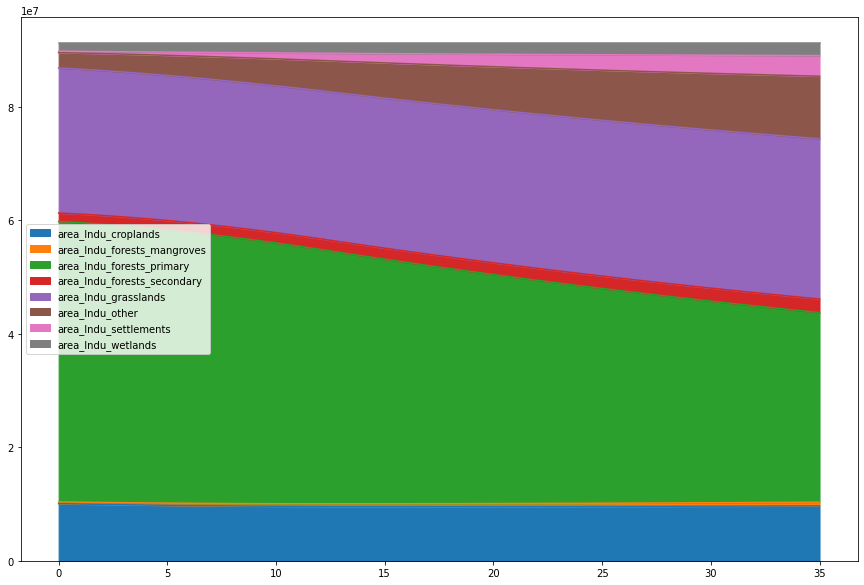